In [1]:
%matplotlib inline
%pylab inline

from functools import partial
import  matplotlib.pyplot as plt
from copy import deepcopy

import menpo.io as mio
from menpo.feature import imgfeature, fast_dsift
from menpo.landmark import labeller, ibug_face_68_trimesh
from menpo.visualize import visualize_images, print_dynamic, plot_graph
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

from menpofit.result import compute_normalise_point_to_point_error, compute_cumulative_error
from menpofit.aam import (
    HolisticAAM, LucasKanadeAAMFitter, 
    holistic_sampling_from_scale,  holistic_sampling_from_step)
from menpofit.aam.algorithm.lk_alabort_arxiv2015 import (
    ProjectOutForwardGaussNewton, 
    ProjectOutInverseGaussNewton,
    ProjectOutAsymmetricGaussNewton,
    ProjectOutBidirectionalGaussNewtonCombined,
    ProjectOutBidirectionalGaussNewtonSimultaneous,
    ProjectOutBidirectionalGaussNewtonAlternated)
from menpofit.visualize import visualize_fitting_result, plot_ced, print_progress

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
@imgfeature
def fast_dsift2(image):
    if image.n_channels == 3:
        image = image.as_greyscale(mode='average')
    return fast_dsift(image)

In [3]:
image_folder = '/Users/joan/PhD/DataBases/faces/'
model_folder = '/Users/joan/PhD/Papers/alabort_arxiv2015_aam/experiments/'
result_folder = model_folder + 'rho/'

## Load AAM

In [4]:
aam = mio.import_pickle(model_folder + 'aam.pkl.gz')

## Load test data

In [5]:
test_images = []
for i in mio.import_images(image_folder + 'lfpw/testset/', 
                           verbose=True, max_images=None):    
    i = i.rescale_landmarks_to_diagonal_range(200)
    i = i.crop_to_landmarks_proportion(0.5)
    labeller(i, 'PTS', ibug_face_68_trimesh)
    if i.n_channels == 3:
        test_images.append(i)

Importing assets: [==========] 100% (224/224) - done.                           


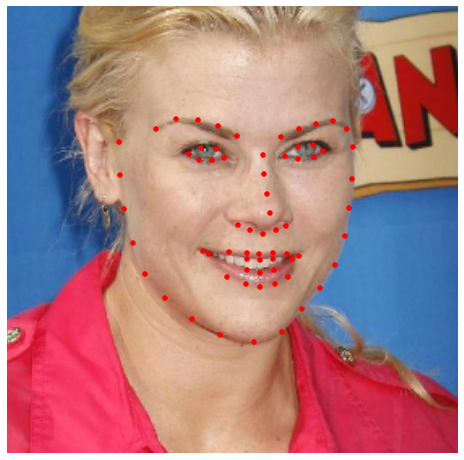

In [6]:
visualize_images(test_images)

## Fit AAM

In [7]:
n_shape = [3, 12]
n_appearance = 0.75
max_iters = [24, 16]
scale = 0.5
noise_percentage = 0.05

repeat = 1

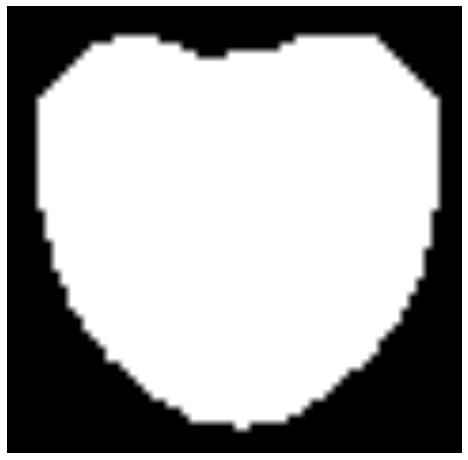

In [8]:
sampling_step_1, sampling_mask_1 = holistic_sampling_from_scale(aam.appearance_models[0].mean(), 
                                                                scale=np.minimum(2 * scale, 1))

sampling_mask_1.view()

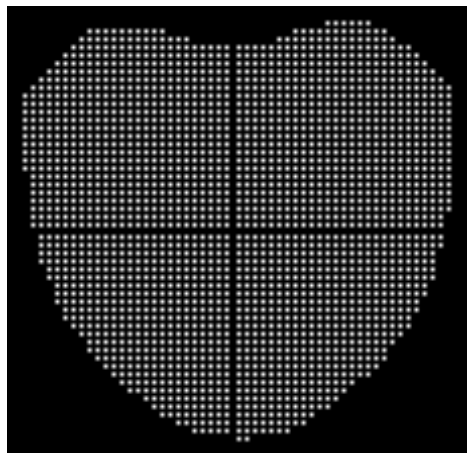

In [9]:
sampling_step_2, sampling_mask_2 = holistic_sampling_from_scale(aam.appearance_models[1].mean(), scale=scale)

sampling_mask_2.view()

In [10]:
sampling_step = [sampling_step_1, sampling_step_2]

#### Sampled AAM Fitters

In [11]:
lambdas = np.hstack(np.arange(0, 1.1, 0.1))

fitters_0 = []
for l in lambdas:

    fitter = LucasKanadeAAMFitter(
        aam, 
        lk_algorithm_cls=partial(ProjectOutForwardGaussNewton, l=l), 
        n_shape=n_shape, 
        n_appearance=n_appearance,
        sampling=sampling_step)
    
    fitters_0.append(fitter)
    
fitters_1 = []
for l in lambdas:

    fitter = LucasKanadeAAMFitter(
        aam, 
        lk_algorithm_cls=partial(ProjectOutInverseGaussNewton, l=l), 
        n_shape=n_shape, 
        n_appearance=n_appearance,
        sampling=sampling_step)
    
    fitters_1.append(fitter)
    
fitters_2 = []
for l in lambdas:

    fitter = LucasKanadeAAMFitter(
        aam, 
        lk_algorithm_cls=partial(ProjectOutAsymmetricGaussNewton, l=l), 
        n_shape=n_shape, 
        n_appearance=n_appearance,
        sampling=sampling_step)
    
    fitters_2.append(fitter)
    

fitters_3 = []
for l in lambdas:

    fitter = LucasKanadeAAMFitter(
        aam, 
        lk_algorithm_cls=partial(ProjectOutBidirectionalGaussNewtonSimultaneous, l=l), 
        n_shape=n_shape, 
        n_appearance=n_appearance,
        sampling=sampling_step)
    
    fitters_3.append(fitter)

In [12]:
sm_0 = fitter.aam.shape_models[0]
sm_1 = fitter.aam.shape_models[1]

print '1st scale -> \tvariance:', sm_0.variance_ratio(), '\tcomponents:', sm_0.n_active_components
print '2nd scale -> \tvariance:', sm_1.variance_ratio(), '\tcomponents:', sm_1.n_active_components

am_0 = fitter.aam.appearance_models[0]
am_1 = fitter.aam.appearance_models[1]

print '1st scale -> \tvariance:', am_0.variance_ratio(), '\tcomponents:', am_0.n_active_components
print '2nd scale -> \tvariance:', am_1.variance_ratio(), '\tcomponents:', am_1.n_active_components

1st scale -> 	variance: 0.757695862498 	components: 3
2nd scale -> 	variance: 0.926468444778 	components: 12
1st scale -> 	variance: 0.750517836986 	components: 225
2nd scale -> 	variance: 0.75026814791 	components: 280


In [73]:
n_fitters = len(fitters_0)
legend_entries = ['Initialization'] + [str(l) for l in lambdas]

#### Fitter 0 fitting loop

In [14]:
fitters_results_0 = []
for j, image in enumerate(repeat * test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters_0[0].noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage, rotation=True)

    for fitter in fitters_0:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results_0.append(fr.as_serializableresult())
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

#### Fitter 1 fitting loop

In [15]:
fitters_results_1 = []
for j, image in enumerate(repeat * test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters_1[0].noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage, rotation=True)

    for fitter in fitters_1:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results_1.append(fr.as_serializableresult())
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

#### Fitter 2 fitting loop

In [16]:
fitters_results_2 = []
for j, image in enumerate(repeat * test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters_2[0].noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage, rotation=True)

    for fitter in fitters_2:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results_2.append(fr.as_serializableresult())
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

#### Fitter 3 fitting loop

In [17]:
fitters_results_3 = []
for j, image in enumerate(repeat * test_images):
    
    np.random.seed(j)
    
    gt_shape = image.landmarks['ibug_face_68_trimesh'].lms
    initial_shape = fitters_3[0].noisy_shape_from_shape(gt_shape, noise_percentage=noise_percentage, rotation=True)

    for fitter in fitters_3:
        
        fr = fitter.fit_from_shape(image, initial_shape, gt_shape=gt_shape, max_iters=max_iters) 
        fr.downscale = 0.5
        fitters_results_3.append(fr.as_serializableresult())
    
        print_dynamic(
            'Image: {} - Initial error: {} - Final error: {}'
            .format(j, fr.initial_error(), fr.final_error()))

## Results

In [18]:
fitters_results = [fitters_results_0,
                   fitters_results_1,
                   fitters_results_2,
                   fitters_results_3]

In [21]:
# mio.export_pickle(fitters_results, result_folder + 'po_gn.pkl.gz')

In [5]:
# fitters_results = mio.import_pickle(result_folder + 'po_gn.pkl.gz')

# n_fitters = 11
# lambdas = np.hstack(np.arange(0, 1.1, 0.1))
# legend_entries = ['Initialization'] + [str(l) for l in lambdas]
# max_iters = [24, 16]
# noise_percentage = 0.05

Produce combined mean error vs rho graph:

In [6]:
mean_errors = []
std_errors = []
median_errors = []
convergence_errors = []

for frs in fitters_results:

    errors = []
    conv_errors = []
    for j in range(n_fitters):
        errors_j = []
        for fr in frs[j::n_fitters]:
            error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                           fr.gt_shape.points[17:, :],
                                                           norm_shape=fr.gt_shape.points)
            errors_j.append(error)
        errors.append(errors_j)
        
        conv_errors.append(compute_cumulative_error(errors_j, np.asarray([0.02, 0.03, 0.04])))

    mean_errs = []
    std_errs = []
    median_errs = []
    for j in range(n_fitters):
        errs = np.asarray(errors[j])
        mean_errs.append(np.mean(errs))
        std_errs.append(np.std(errs))
        median_errs.append(np.median(errs))
    
    mean_errors.append(mean_errs)
    std_errors.append(std_errs)
    median_errors.append(median_errs)
    
    convergence_errors.append(conv_errors)
    
mean_errors_matrix = np.asarray(mean_errors).T
std_errors_matrix = np.asarray(std_errors).T
median_errors_matrix = np.asarray(median_errors).T
convergence_errors_matrix = np.asarray(convergence_errors).T

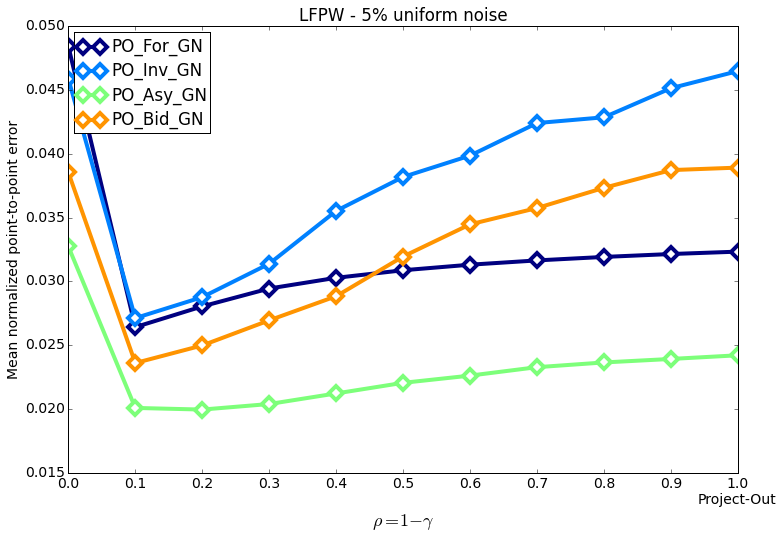

In [7]:
import  matplotlib.pyplot as plt
from menpo.visualize.viewmatplotlib import sample_colours_from_colourmap

colours = sample_colours_from_colourmap(4, 'jet')

fig = plt.figure()
plt.hold(True)

for i in range(mean_errors_matrix.shape[1]):
    plt.plot(np.arange(0, len(mean_errors_matrix[:, i])), 
             mean_errors_matrix[:, i],
             color=colours[i],
             linewidth=4,
             marker='D',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel(r'$\rho = 1 - \gamma$', fontsize=18)
plt.ylabel('Mean normalized point-to-point error')
plt.xlim((0, 1))
#plt.ylim((0.01, 0.05))

width = mean_errors_matrix.shape[0]
x_axis_labels = legend_entries[1:]
x_axis_labels[-1] = x_axis_labels[-1] + '\nProject-Out' 
plt.xticks(range(width), x_axis_labels[:width])

plt.legend(['PO_For_GN', 'PO_Inv_GN', 'PO_Asy_GN', 'PO_Bid_GN'], loc=2)

plt.title('LFPW - {}% uniform noise '.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_folder + 'mean_error_vs_rho_{}.png'.format(int(100*noise_percentage)),
            format='png', dpi=300, bbox_inches='tight')

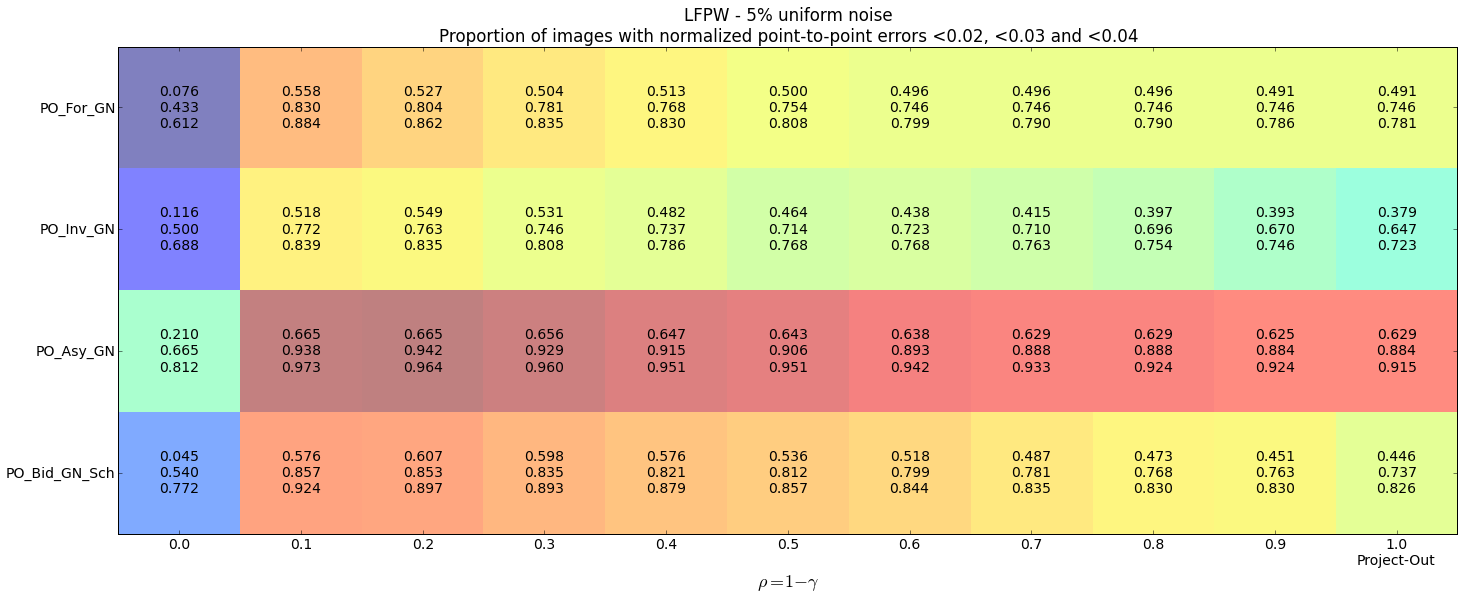

In [8]:
mean_errors_matrix = np.asarray(mean_errors)
std_errors_matrix = np.asarray(std_errors)
median_errors_matrix = np.asarray(median_errors)

fig = plt.figure()
plt.clf()
ax = fig.add_subplot(111)
ax.set_aspect(1)
res = ax.imshow(np.array(convergence_errors_matrix[1].T), cmap=plt.cm.jet, 
                alpha=0.5, interpolation='nearest')

height, width = mean_errors_matrix.shape

for x in xrange(width):
    for y in xrange(height):
        ax.annotate("{:.3f}\n{:.3f}\n{:.3f}".format
                    (convergence_errors_matrix[0][x][y], 
                     convergence_errors_matrix[1][x][y], 
                     convergence_errors_matrix[2][x][y]), 
                    xy=(x, y), 
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='black')

#cb = fig.colorbar(res, orientation='horizontal')
y_axis_labels = ['PO_For_GN', 'PO_Inv_GN', 'PO_Asy_GN', 'PO_Bid_GN_Sch']
x_axis_labels = legend_entries[1:]
x_axis_labels[-1] = x_axis_labels[-1] + '\nProject-Out' 
plt.xticks(range(width), x_axis_labels[:width])
plt.yticks(range(height), y_axis_labels[:height])
plt.xlabel(r'$\rho = 1 - \gamma$', fontsize=18)
#plt.ylabel('Algorithms')

plt.title('LFPW - {}% uniform noise\nProportion of images with normalized point-to-point errors <0.02, <0.03 and <0.04'.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(4 * fig.get_size_inches())

plt.savefig(result_folder + 'convergence_vs_rho_po_gn_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300, bbox_inches='tight')

Produce CED graph for Project-Out Forward Gauss-Newton:

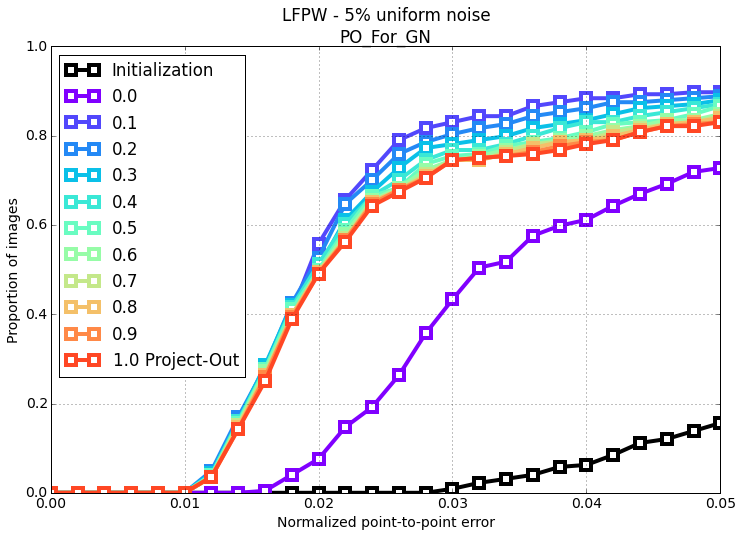

In [77]:
errors = [[]]
for fr in fitters_results[0][::n_fitters]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[0][j::n_fitters]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)
    

x_axis =  np.arange(0, 0.052, 0.002)

cumulative_errors = []
for err in errors:
    cumulative_errors.append(compute_cumulative_error(err, x_axis))
    
    
colours = ['black'] + sample_colours_from_colourmap(len(errors)-1, 'rainbow')

fig = plt.figure()
plt.hold(True)

for i in range(len(errors)):
    plt.plot(x_axis,
             cumulative_errors[i],
             color=colours[i],
             linewidth=4,
             marker='s',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel('Normalized point-to-point error')
plt.ylabel('Proportion of images')
plt.xlim((x_axis[0], x_axis[-1]))
plt.ylim((0, 1))
aux = deepcopy(legend_entries)
aux[-1] = aux[-1] + ' Project-Out'
plt.legend(aux, loc=2)
plt.grid(True)

plt.title('LFPW - {}% uniform noise \nPO_For_GN'.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_folder + 'ced_po_for_gn_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300, bbox_inches='tight')

Produce CED graph for Project-Out Inverse Gauss-Newton:

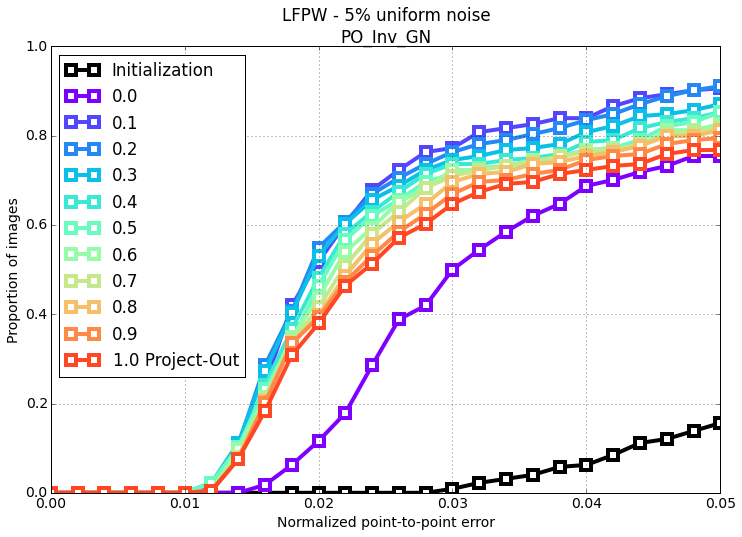

In [80]:
errors = [[]]
for fr in fitters_results[1][::n_fitters]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[1][j::n_fitters]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)
    

x_axis =  np.arange(0, 0.052, 0.002)

cumulative_errors = []
for err in errors:
    cumulative_errors.append(compute_cumulative_error(err, x_axis))
    
    
colours = ['black'] + sample_colours_from_colourmap(len(errors)-1, 'rainbow')

fig = plt.figure()
plt.hold(True)

for i in range(len(errors)):
    plt.plot(x_axis,
             cumulative_errors[i],
             color=colours[i],
             linewidth=4,
             marker='s',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel('Normalized point-to-point error')
plt.ylabel('Proportion of images')
plt.xlim((x_axis[0], x_axis[-1]))
plt.ylim((0, 1))
aux = deepcopy(legend_entries)
aux[-1] = aux[-1] + ' Project-Out'
plt.legend(aux, loc=2)
plt.grid(True)

plt.title('LFPW - {}% uniform noise \nPO_Inv_GN'.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_folder + 'ced_po_inv_gn_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300, bbox_inches='tight')

Produce CED graph for Project-Out Asymmetric Gauss-Newton:

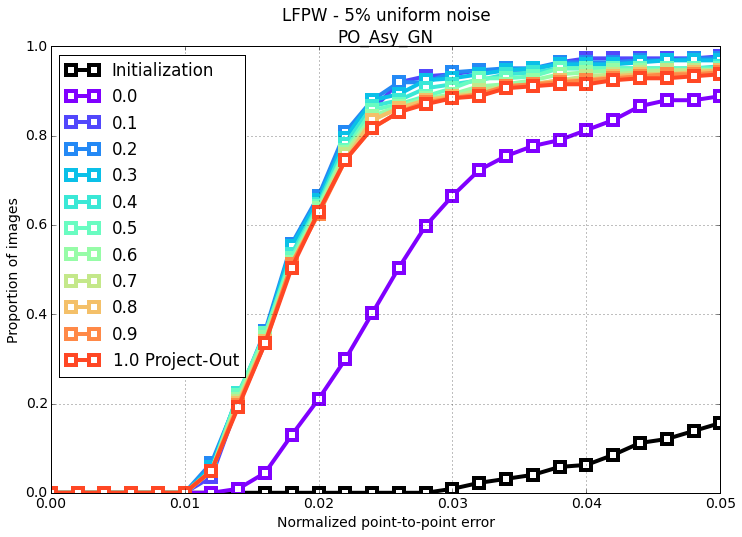

In [78]:
errors = [[]]
for fr in fitters_results[2][::n_fitters]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[2][j::n_fitters]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)
  

x_axis =  np.arange(0, 0.052, 0.002)

cumulative_errors = []
for err in errors:
    cumulative_errors.append(compute_cumulative_error(err, x_axis))
    
    
colours = ['black'] + sample_colours_from_colourmap(len(errors)-1, 'rainbow')

fig = plt.figure()
plt.hold(True)

for i in range(len(errors)):
    plt.plot(x_axis,
             cumulative_errors[i],
             color=colours[i],
             linewidth=4,
             marker='s',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel('Normalized point-to-point error')
plt.ylabel('Proportion of images')
plt.xlim((x_axis[0], x_axis[-1]))
plt.ylim((0, 1))
aux = deepcopy(legend_entries)
aux[-1] = aux[-1] + ' Project-Out'
plt.legend(aux, loc=2)
plt.grid(True)

plt.title('LFPW - {}% uniform noise \nPO_Asy_GN'.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_folder + 'ced_po_asy_gn_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300, bbox_inches='tight')

Produce CED graph for Project-Out Bidirectional Gauss-Newton:

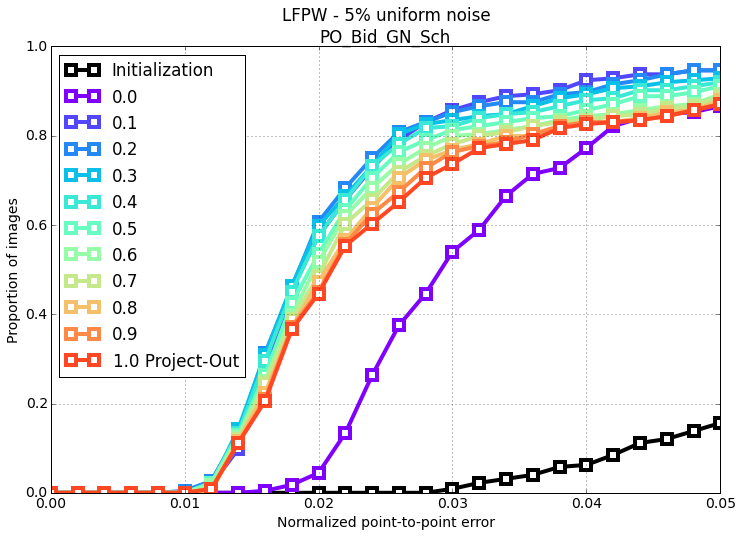

In [10]:
errors = [[]]
for fr in fitters_results[3][::n_fitters]:
    error = compute_normalise_point_to_point_error(fr.initial_shape.points[17:, :], 
                                                   fr.gt_shape.points[17:, :],
                                                   norm_shape=fr.gt_shape.points)
    errors[0].append(error)

for j in range(n_fitters):
    errors_j = []
    for fr in fitters_results[3][j::n_fitters]:
        error = compute_normalise_point_to_point_error(fr.final_shape.points[17:, :], 
                                                       fr.gt_shape.points[17:, :],
                                                       norm_shape=fr.gt_shape.points)
        errors_j.append(error)
    errors.append(errors_j)
  

x_axis =  np.arange(0, 0.052, 0.002)

cumulative_errors = []
for err in errors:
    cumulative_errors.append(compute_cumulative_error(err, x_axis))
    
    
colours = ['black'] + sample_colours_from_colourmap(len(errors)-1, 'rainbow')

fig = plt.figure()
plt.hold(True)

for i in range(len(errors)):
    plt.plot(x_axis,
             cumulative_errors[i],
             color=colours[i],
             linewidth=4,
             marker='s',
             mec=colours[i],
             mfc='w',
             markersize=10,
             mew=4)
    
plt.xlabel('Normalized point-to-point error')
plt.ylabel('Proportion of images')
plt.xlim((x_axis[0], x_axis[-1]))
plt.ylim((0, 1))
aux = deepcopy(legend_entries)
aux[-1] = aux[-1] + ' Project-Out'
plt.legend(aux, loc=2)
plt.grid(True)

plt.title('LFPW - {}% uniform noise \nPO_Bid_GN_Sch'.format(int(100*noise_percentage)))

plt.rcParams.update({'font.size': 14})

fig.set_size_inches(2 * fig.get_size_inches())

plt.savefig(result_folder + 'ced_po_bid_gn_{}.png'.format(int(100*noise_percentage)), 
            format='png', dpi=300, bbox_inches='tight')

## Other

In [ ]:
# import line_profiler
# import IPython

# ip = IPython.get_ipython()
# ip.define_magic('lprun', line_profiler.magic_lprun)

In [ ]:
# %lprun -f ProjectOutAsymmetricGaussNewton._solve fitter_3.fit_from_shape(i, s, gt_shape=gt_s, max_iters=2) 